## Treasure Hunters Inc.

The main goal of this project is to solve a Treasure Hunt map like environment using Reinforcement Learning. I used QLearning algorithm for this project.

### Description of maze

The maze used is very simple. It includes opponents, obstacles, treasures at different positions in the maze. The aim of the reinforcement learning agent is to find the best path collecting treasures till you reach the destination while avoiding the obstacles.

Here, the reward is calculated if agent collects the treasure and the total reward is displayed by adding all the treasures until it reaches the destiantion.

### Q-Learning

To acheive the optimal path to find treasure, I used Q Learning algorithm. Rewards will be added associated with an action and the quality of the action dictated by history of moves that follows the action learnt by agent through experience. 

The agent here, learns to navigate by the train function defined and using Bellman Equation the quality matrix Q is updated to gather experience by the agent. Once, training is done, the agent has learned the maze and on giving starting point and final destination the agent can navigate and collect treasures in maze.




## Importing required libraries

In [1]:
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore") # Supress MatPlotLib Warning

## Q Learning Implementation

Below are the functions required to get the best path without any obstacles and opponents.

In [2]:
#This function defines the different types of moves more specifically different directions from each state - N, E, W, S.
# We don't define stop move since on reaching destination the agent will automatically halt.

def move_direction(state, move):
    if move == 0:   # North
        return state - width
    elif move == 1: # East
        return state + 1
    elif move == 2: # South
        return state + width
    elif move == 3: # West
        return state - 1
    else:
        raise Exception

In [3]:
#possible move function returns the possible moves that are without any obstacles or opponents from any arbituary state.
def possible_moves(s, M):
    pmove = []
    correct_move = []
    x, y = StateToPos(s)
    if y > 0:
        correct_move.append(0)
    if x < len(M[0]) - 1:
        correct_move.append(1)
    if y < len(M) - 1:
        correct_move.append(2)
    if x > 0:
        correct_move.append(3)
    for move in correct_move:
            poss_state = move_direction(s,move)
            x,y = StateToPos(poss_state)
            if M[y][x] != OBSTACLE: pmove.append(move)
    return pmove

In [4]:
#This function uses the Q matrix and gets the best move from one state to reach another state until it reaches the destination.
def best_move(s, M, Q):
    pnextmove = possible_moves(s, M)
    if len(pnextmove) == 0:
            return None
    max_m = pnextmove[0]
    max_q = Q[s][max_m]

    for move in pnextmove[1::]:
        if(Q[s][move] > max_q):
            max_q, max_m = Q[s][move], move
    return max_m

In [5]:
#Gets the next move by either exploring or exploiting
def random_move(s, M, Q):
    pnextmove = possible_moves(s, M)
    if len(pnextmove) == 0:
            return None
    if np.random.rand() <= exploit_prob:
        return best_move(s, M, Q)
    else:
        next_move = \
            pnextmove[np.random.randint(0,\
            len(pnextmove))]
        return next_move

In [6]:
#Functions to convert from state to positions and vice versa.
def StateToPos(s):
    return s % width, s // width
def PosToState(x,y):
    return y*width+x

### Implementation of train function to train the agent.

In [7]:
def train(M, Q, gamma, lrn_rate, destination, ns, max_epochs, startingState, max_steps):
    for _ in range(0,max_epochs):
        M_copy = np.copy(M)
        curr_s = 0
        steps = 0
        x,y = StateToPos(curr_s)
        points = M_copy[y][x]
        M_copy[y][x] = OBSTACLE # Converts the path previously walked on to disalow backtracking
        while(True):
            next_m = random_move(curr_s, M_copy, Q)
            if next_m is None:
                break
            next_s = move_direction(curr_s,next_m)
            x,y = StateToPos(next_s)
            next_r = M_copy[y][x]
            points += next_r

            M_copy[y][x] = OBSTACLE

            bestnextnextMove = best_move(next_s, M_copy, Q)
            max_Q = -1
            if bestnextnextMove is not None:
                max_Q = Q[next_s][bestnextnextMove]
                
            Q[curr_s][next_m] = Q[curr_s][next_m] + (lrn_rate) * \
                                                    ( next_r + (gamma * max_Q) - Q[curr_s][next_m] )

            #update Q matrix based on the formula from class
            
            curr_s = next_s
            steps += 1
            if curr_s == destination: break
            if steps == max_steps: break # Max steps specified to quicken algorithm from excessively long paths.

In [8]:
#Returns a path based on the best move from the highest values in the Q matrix
def best_path(start, destination, Q, M, max_steps):
    M_copy = np.copy(M)
    steps = 1
    curr = start
    curr_x, curr_y = StateToPos(curr)
    points = M_copy[curr_y][curr_x]
    M_copy[curr_y][curr_x] = OBSTACLE
    print(str((curr_x,curr_y)), end="")
    path = [[.5,.5]]
    while curr != destination and steps < max_steps:
        next_m = best_move(curr, M_copy, Q)
        if next_m is None:
            break
        next = move_direction(curr,next_m)
        curr_x, curr_y = StateToPos(curr)
        x, y = StateToPos(next)
        path.append([x+.5,y+.5])
        print("->" + str((x,y)), end="")
        points += M_copy[y,x]
        M_copy[y][x] = OBSTACLE

        curr = next
        steps += 1
        
    return np.array(path),points

## Function to print the Treasure map



In [9]:
#This function will have all the variables needed to print the map with different blocks. The blocks in the map includes Obstacles, Score, Opponent.
def Treasure_Map(M, path=None):
    cmap = mpl.colors.ListedColormap(['Navy', 'firebrick', 'darkgreen','white'])
    M_copy = np.copy(M)

   # Scaling the Map for colormesh  
    minimum = int(np.amin(M))-1
    M_copy[abs(M_copy - GROUND) < .01]   = minimum-1
    M_copy[abs(M_copy - TREASURE) < .01] = minimum-2
    M_copy[abs(M_copy - OBSTACLE) < .01] = minimum-3
    M_copy[abs(M_copy - OPPONENT) < .01] = minimum-4

    M_copy[M_copy is minimum-1] = 0
    M_copy[M_copy is minimum-2] = 1
    M_copy[M_copy is minimum-3] = 2
    M_copy[M_copy is minimum-4] = 3
    

    plt.pcolormesh(M_copy, cmap=cmap)

    green_patch = mpl.patches.Patch(color='white', label='Ground')
    gold_patch = mpl.patches.Patch(color='darkgreen', label='Treasure')
    brown_patch = mpl.patches.Patch(color='firebrick', label='Obstacle')
    blue_patch = mpl.patches.Patch(color='Navy', label='Opponent')
    handles = [green_patch, gold_patch, brown_patch, blue_patch]
    plt.subplots_adjust(right=0.7)
    
    if path is not None:
        plt.plot(*path.T, color='purple')
        red_patch = mpl.patches.Patch(color='purple', label='Path')
        handles.append(red_patch)
    plt.legend(handles=handles ,loc='upper left', bbox_to_anchor=(1.04,1), borderaxespad=0)
    plt.axes().set_aspect('equal') #same scale for x and y axis.
    plt.xticks(np.arange(0, len(M), 1)) # remove the tick marks by setting to an empty list
    plt.yticks(np.arange(0, len(M[0]), 1)) # remove the tick marks by setting to an empty list
    plt.grid()
    plt.axes().invert_yaxis() #inverting the y-axis so that the first row of data is at the top

## Reward Calculations:

For the maze designed, on collecting the treasures starting from start point and until it reach the destiantion, the values are summed and total reward is displayed.

On passing the treasure, 5 points will be added and if any opponent is touched while navigating, 5 points will be deducted from the total reward till that point. While navigating, the otehr blocks apart from treasures, obstacles and opponents, a minute 0.25 will be deducting from the total rewards. In this way, we can get the reward as well as the optimal path when agent reaches the destiantion.

## Initializing the variable values required for treasure map.

In [10]:
GROUND = -0.25
TREASURE = 5
OBSTACLE = 0
OPPONENT = -5
height = 15
width = 15

## Plot the treasure map with obstacles, opponent and treasure

In [11]:
M = np.full((width,height), GROUND)
shape = M.shape
M = M.flatten()
np.random.seed(2)
treasureIndecies = np.random.choice(M.size, size=20)
M[treasureIndecies] = TREASURE
M = M.reshape(shape)

M[1][0] = TREASURE; M[2][1] = TREASURE; M[3][2] = TREASURE; M[4][3] = TREASURE

M[5,1] = OBSTACLE; M[6,1] = OBSTACLE; M[7,1] = OBSTACLE; M[8,1] = OBSTACLE
M[11,1] = OBSTACLE; M[12,1] = OBSTACLE; M[13,1] = OBSTACLE; M[14,1] = OBSTACLE
M[11,2] = OBSTACLE; M[11,3] = OBSTACLE; M[11,4] = OBSTACLE; M[11,5] = OBSTACLE

M[10,4] = OPPONENT; M[4,3] = OPPONENT; M[5,10] = OPPONENT; M[14,4] = OPPONENT

M[0,0] = GROUND
M[14,14] = TREASURE

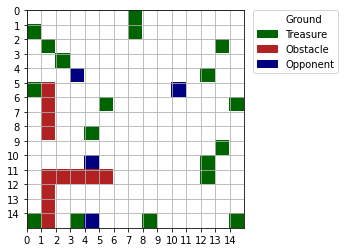

In [12]:
Treasure_Map(M)

## Initializing the values required for training - QLearning.

In [13]:
start_state = 0
state_count = M.size
final_state = state_count - 1
move_options = 4
gamma = .5
lrn_rate = .2
max_epochs = 1000
max_steps = 100
exploit_prob = .8

## Training the treasure map with given parameters.

In [14]:
Q = np.zeros(shape=[state_count,move_options], dtype=np.float32)  # Quality
train(M, Q, gamma, lrn_rate, final_state, state_count, max_epochs, 0, max_steps)

## Printing the path

On running the below block, we can see the points from which the path was obtained travelled from starting point to end point which is the destination.

Path from (0, 0) to (14, 14)
(0, 0)->(0, 1)->(0, 2)->(1, 2)->(2, 2)->(2, 3)->(1, 3)->(0, 3)->(0, 4)->(0, 5)->(0, 6)->(0, 7)->(0, 8)->(0, 9)->(1, 9)->(2, 9)->(3, 9)->(3, 8)->(4, 8)->(4, 7)->(4, 6)->(5, 6)->(6, 6)->(7, 6)->(7, 5)->(7, 4)->(7, 3)->(7, 2)->(7, 1)->(7, 0)->(8, 0)->(8, 1)->(8, 2)->(9, 2)->(10, 2)->(10, 3)->(10, 4)->(11, 4)->(12, 4)->(12, 3)->(13, 3)->(13, 2)->(14, 2)->(14, 3)->(14, 4)->(14, 5)->(14, 6)->(14, 7)->(13, 7)->(13, 8)->(13, 9)->(13, 10)->(12, 10)->(12, 11)->(13, 11)->(13, 12)->(14, 12)->(14, 13)->(14, 14)


Total rewards for path is: 64.0


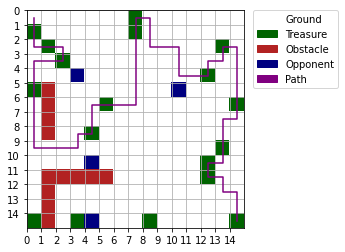

In [15]:
Q = np.zeros(shape=[state_count,move_options], dtype=np.float32)
train(M, Q, gamma, lrn_rate, final_state, state_count, max_epochs, 0, max_steps)
print("Path from", StateToPos(start_state), "to", StateToPos(final_state))
path,points = best_path(start_state, final_state, Q, M, max_steps)
Treasure_Map(M,path)
print("\n")
print("\nTotal rewards for path is:", points)

This path is the best path obtained without touching any obstacles or opponents. The reward can reach till 67 if few other treasure blocks are covered but we got an accuracy of 95% using qlearning algorithm. This algorithm is easy to understand and gave results with atmost accuracy.

## Changing the positions

We are changing the positions of obstacles, treasure and opponents in order to see if the optimal path obtained will not hit any obstacle or opponent.

In [16]:
M = np.full((width,height), GROUND)
shape = M.shape
M = M.flatten()
treasureIndecies = np.random.choice(M.size, size=15)
obsticleIndecies = np.random.choice(M.size, size=20)
opponentIndecies = np.random.choice(M.size, size=5)

M[treasureIndecies] = TREASURE
M[obsticleIndecies] = OBSTACLE
M[opponentIndecies] = OPPONENT

M = M.reshape(shape)

M[0,0] = GROUND
M[14,14] = TREASURE

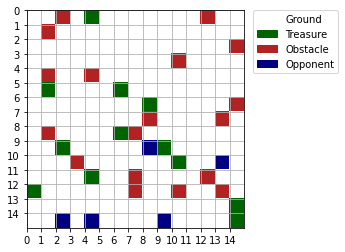

In [17]:
Treasure_Map(M)

Path from (0, 0) to (14, 14)
(0, 0)->(0, 1)->(0, 2)->(0, 3)->(0, 4)->(0, 5)->(1, 5)->(2, 5)->(2, 6)->(2, 7)->(2, 8)->(2, 9)->(2, 10)->(2, 11)->(3, 11)->(4, 11)->(4, 10)->(5, 10)->(5, 9)->(5, 8)->(6, 8)->(6, 7)->(6, 6)->(6, 5)->(7, 5)->(8, 5)->(8, 6)->(9, 6)->(9, 7)->(9, 8)->(9, 9)->(9, 10)->(10, 10)->(10, 11)->(11, 11)->(11, 12)->(11, 13)->(12, 13)->(13, 13)->(14, 13)->(14, 14)


Total rewards for path is: 42.25


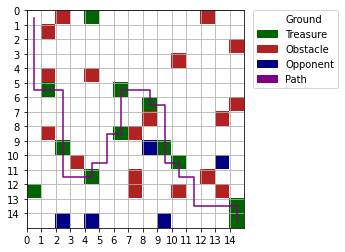

In [18]:
Q = np.zeros(shape=[state_count,move_options], dtype=np.float32)
train(M, Q, gamma, lrn_rate, final_state, state_count, max_epochs, 0, max_steps)
print("Path from", StateToPos(start_state), "to", StateToPos(final_state))
path,points = best_path(start_state, final_state, Q, M, max_steps)
Treasure_Map(M,path)
print("\n")
print("\nTotal rewards for path is:", points)

The path from the above plot is pretty good, It is not optimal since, the treasure at (0, 12) can be covered which will add the total rewards by 3.5. But it is 93% optimal if you observe other treasures are covered.

## Conclusion:

From the above two plots with different positions of Obstacles, opponents and treasure, we can observe that using QLearning we obtained the optimal path by covering most of the treasure blocks with no opponents or obstacles. Further, more optimal paths can be obtained by adjusting the parameters used while training the map.